<a href="https://colab.research.google.com/github/Sawera557/Llava_v1.5_13b-Model-Colab/blob/main/LLaVA_13b_colab_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Llava V1.5-13B

#### LLaVA-1.5 achieves State-of-the-Art (SoTA) performance on 11 benchmarks. With minimal adjustments to the original LLaVA, it leverages all publicly available data, completes training in approximately one day on a single 8-A100 node, and surpasses methods utilizing billion-scale data.

####LLaVA is a pioneering large multimodal model, integrating a vision encoder and Vicuna for comprehensive visual and language understanding. It demonstrates remarkable chat capabilities reminiscent of multimodal GPT-4, setting a new accuracy benchmark on Science QA.

#### **Abstract:**
#####While instruction tuning large language models (LLMs) using machine-generated instruction-following data has enhanced zero-shot capabilities in the language domain, its application in the multimodal field remains relatively unexplored.

#### **Multimodal Instruction Data:**
#####We present the inaugural endeavor to employ language-only GPT-4 for generating multimodal language-image instruction-following data.

####**LLaVA Model:**
#####Introducing LLaVA (Large Language-and-Vision Assistant), an end-to-end trained large multimodal model bridging a vision encoder and LLM for versatile visual and language comprehension.

####**Performance:**
#####Early experiments showcase LLaVA's impressive multimodal chat capabilities, occasionally mirroring behaviors of multimodal GPT-4 on unseen images/instructions. It achieves an 85.1% relative score compared to GPT-4 on a synthetic multimodal instruction-following dataset. Upon fine-tuning for Science QA, the synergy of LLaVA and GPT-4 attains a new state-of-the-art accuracy.

##LLaVA Model Load Setup and Image Captioning Function



In [ ]:
%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA

!pip install -q transformers==4.36.2
!pip install -q gradio .

from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

import os
import requests
from PIL import Image
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image_file, prompt):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

/content
Cloning into 'LLaVA'...
remote: Enumerating objects: 1960, done.
remote: Counting objects: 100% (1024/1024), done.
remote: Compressing objects: 100% (408/408), done.
remote: Total 1960 (delta 692), reused 616 (delta 616), pack-reused 936
Receiving objects: 100% (1960/1960), 13.78 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (1238/1238), done.
/content/LLaVA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 33.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.5 MB/s eta 0:00:00
    

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

##Test Image Captioning with LLaVA Model

###Input

*   Image Path
*   Prompt





### Prompt: Describe the image and color details.

The image features a wooden pier extending out into a large body of water, possibly a lake. The pier is surrounded by a serene and picturesque environment, with a forest visible in the background. The sky above the scene is cloudy, adding to the tranquil atmosphere. The wooden pier has a few benches placed along it, providing a place for visitors to sit and enjoy the view. The water appears to be calm and clear, making it an inviting spot for relaxation and contemplation.


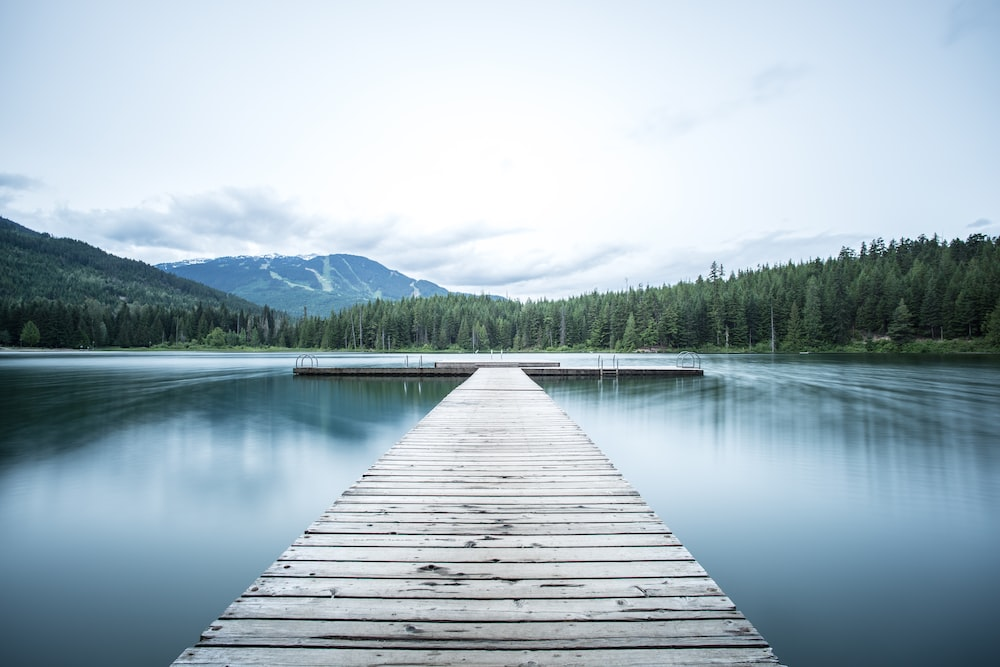

In [ ]:
image, output = caption_image(f'https://llava-vl.github.io/static/images/view.jpg', 'Describe the image and color details.')
print(output)
image

The image features a person standing on a rocky surface, with their arms outstretched, possibly enjoying the view or embracing the moment. The sky above them is filled with a beautiful pink hue, indicating that the sun is setting. The scene is set against a backdrop of clouds, which adds to the picturesque atmosphere. The person's position and posture suggest a sense of freedom and connection with nature.


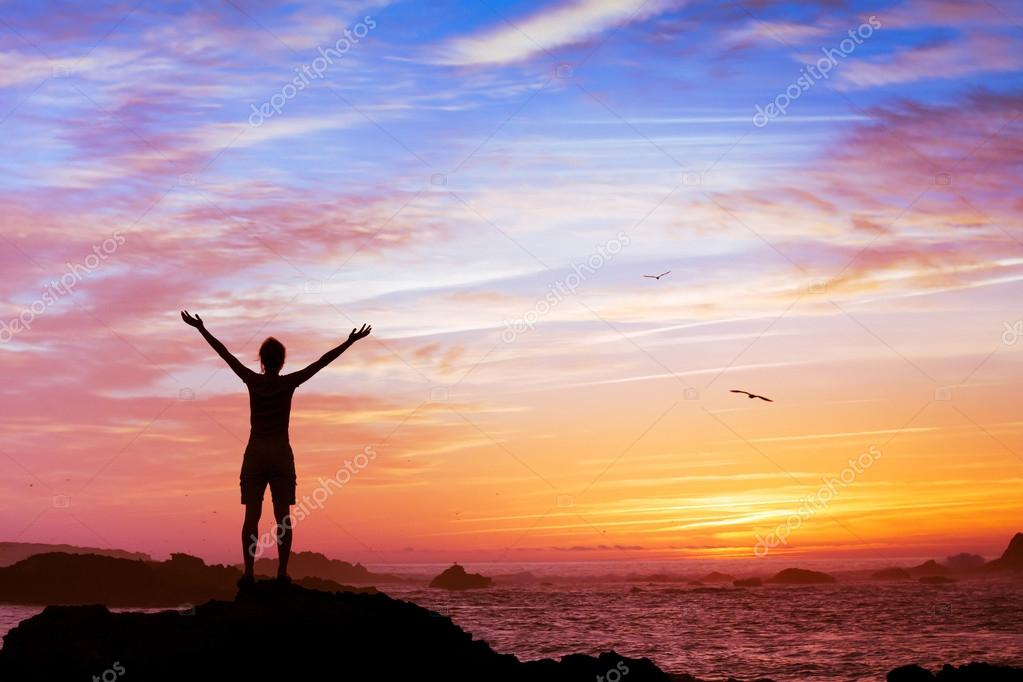

In [ ]:
image, output = caption_image(f'https://st2.depositphotos.com/1757635/5948/i/950/depositphotos_59482257-stock-photo-woman-on-beautiful-sunset.jpg', 'Describe the image and color details.')
print(output)
image

The image features a man in mid-air, jumping over a body of water, possibly a lake or a river. He is wearing a white shirt and black shorts, and his arms are spread wide as he leaps. The scene is captured in black and white, giving it a timeless and dramatic feel. The man's silhouette is visible against the backdrop of the water, creating a striking contrast between the subject and the environment.


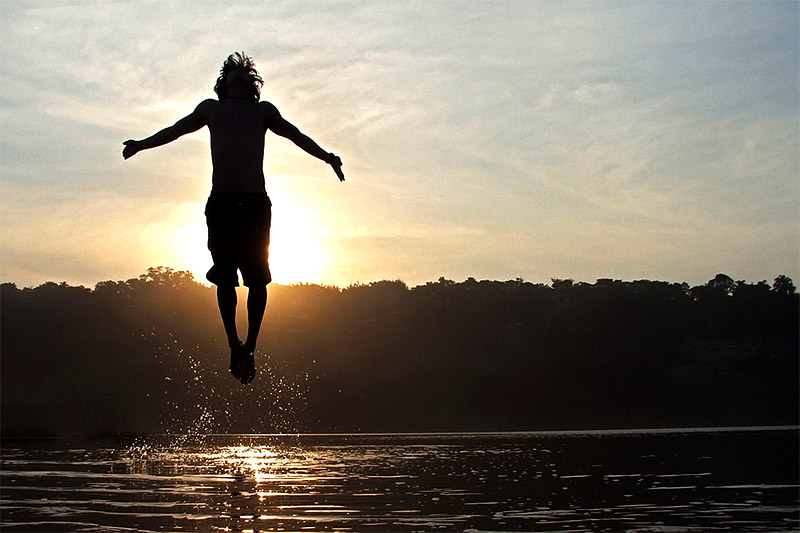

In [ ]:
#https://personalexcellence.co/files/guy-rising-sea.jpg

image, output = caption_image(f'https://personalexcellence.co/files/guy-rising-sea.jpg', 'Describe the image and color details.')
print(output)
image

### Prompt: I'm here right now what to do I'm getting late

I'm sorry to hear that you are getting late. In this situation, you might consider using alternative transportation methods, such as public transit, carpooling, or biking, to avoid the heavy traffic. If these options are not feasible, you could also try to find a different route that may be less congested. Additionally, you can use this time to plan your schedule better in the future to avoid such situations.


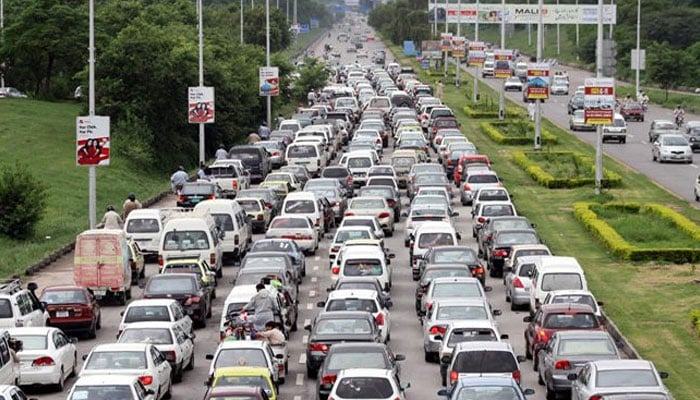

In [ ]:
#https://www.thenews.com.pk/assets/uploads/akhbar/2022-01-20/926645_8595908_ring-road_akhbar.jpg

image, output = caption_image(f'https://www.thenews.com.pk/assets/uploads/akhbar/2022-01-20/926645_8595908_ring-road_akhbar.jpg', "I'm here right now what to do I'm getting late" )
print(output)
image

### Prompt: I'm at hospital My aunt is in critical situation

I'm sorry to hear that your aunt is in a critical situation. It's important to stay positive and supportive during this time. Is there anything specific you would like to know or discuss related to her condition or the hospital environment?


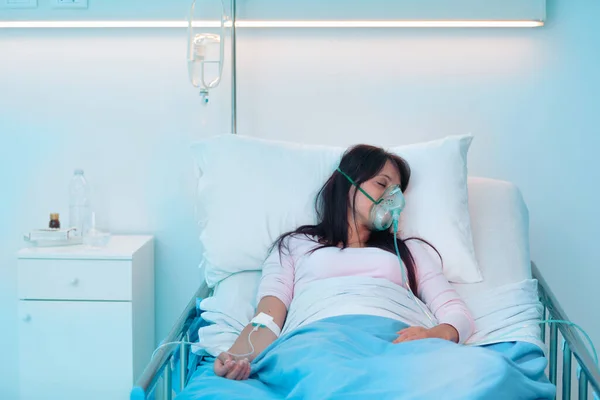

In [ ]:
#https://st4.depositphotos.com/2719405/38645/i/450/depositphotos_386456354-stock-photo-young-woman-lying-hospital-bed.jpg
image, output = caption_image(f'https://st4.depositphotos.com/2719405/38645/i/450/depositphotos_386456354-stock-photo-young-woman-lying-hospital-bed.jpg', "I'm at hospital My aunt is in critical situation" )
print(output)
image

### Prompt: I'm at new year celebration party with my friends I'm really enjoying

That sounds like a great time! I hope you have a fantastic time with your friends, and enjoy the fireworks display in the background.


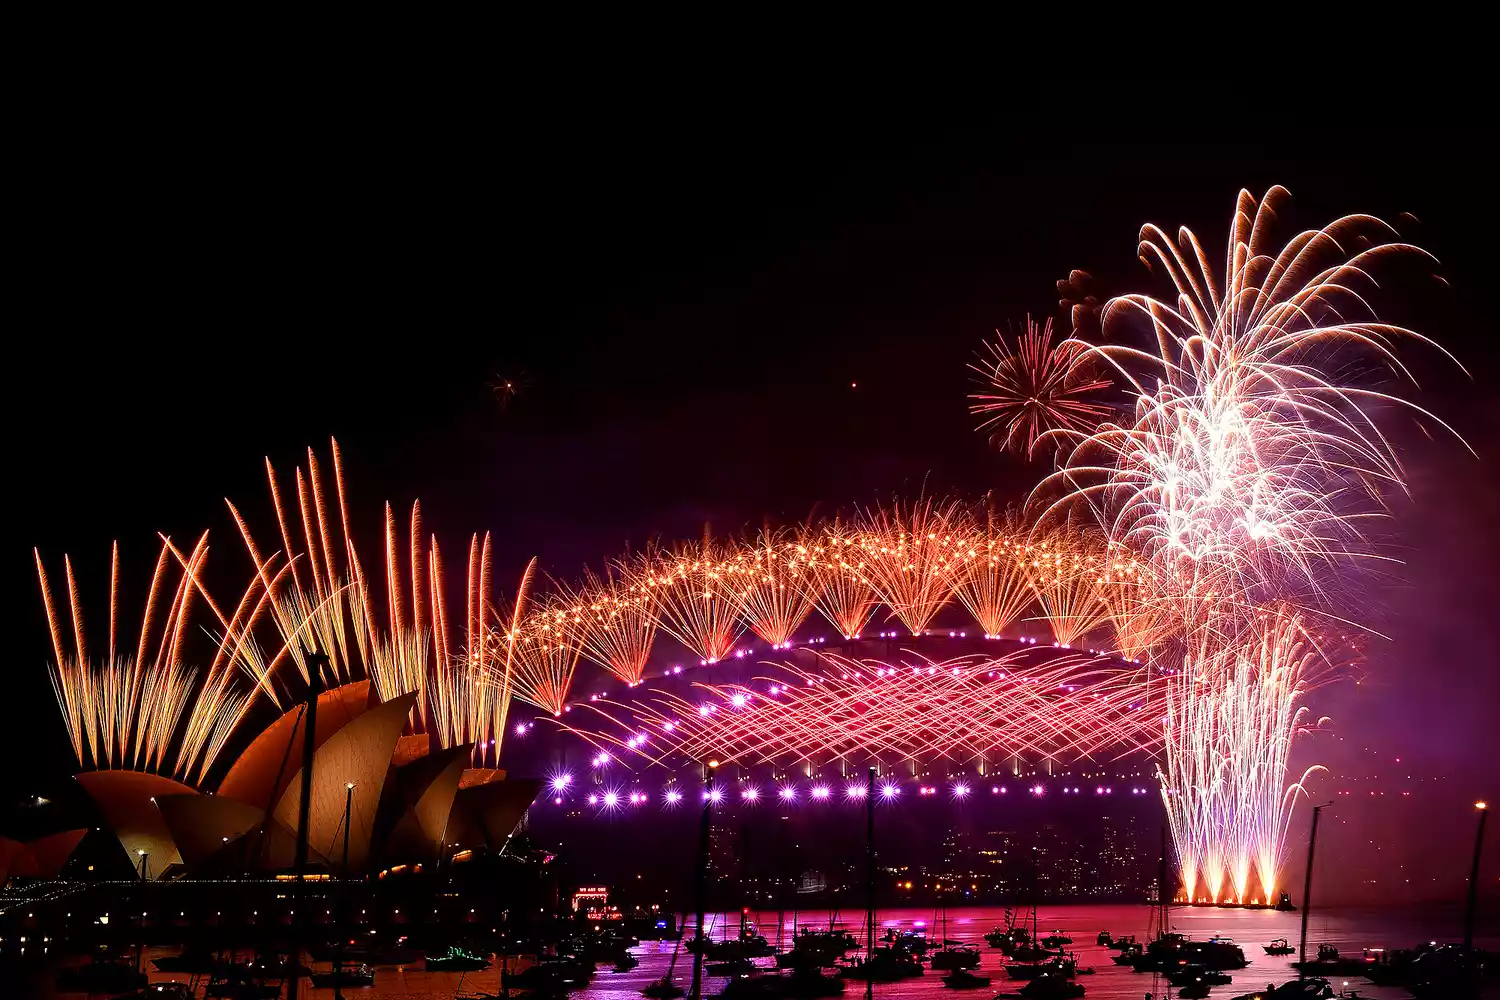

In [ ]:
#https://st4.depositphotos.com/2719405/38645/i/450/depositphotos_386456354-stock-photo-young-woman-lying-hospital-bed.jpg
img = "https://people.com/thmb/iuDVgi_p-LtvNyg8uR14k9oGVK0=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():focal(919x625:921x627):format(webp)/australia-a417a5c466274aaa873fe8e1c7be794e.jpg"
prompt = "I'm at new year celebration party with my friends I'm really enjoying"
image, output = caption_image(img, prompt)
print(output)
image

### Prompt: I'm at office and we are discussing a solution but the team seems like to be fighting with each other swords in their mouth

It sounds like the team is engaged in a heated discussion or debate, possibly over a disagreement or differing opinions on a particular issue. It's important to maintain a respectful and open-minded approach during such discussions, as it can help foster a productive and collaborative work environment. Encouraging open communication and actively listening to each other's perspectives can help to resolve conflicts and find solutions that work for everyone involved.


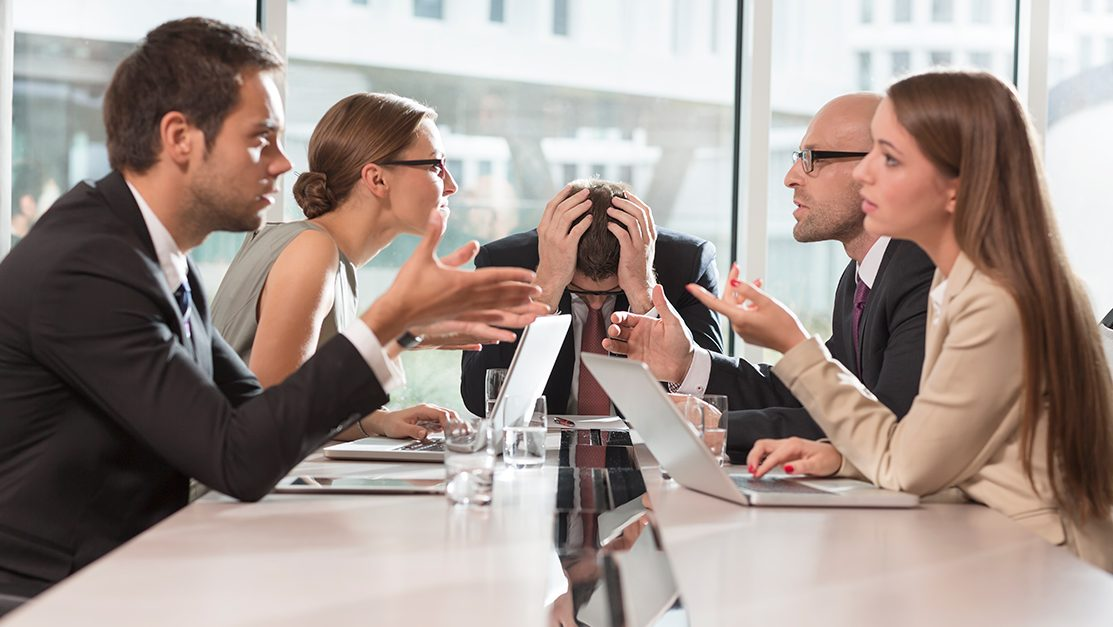

In [ ]:
#https://www.insidehook.com/wp-content/uploads/2017/03/office-argument-0317-e1489793645507-1.jpg
img = "https://www.insidehook.com/wp-content/uploads/2017/03/office-argument-0317-e1489793645507-1.jpg"
prompt = "I'm at office and we are discussing a solution but the team seems like to be fighting with each other swords in their mouth "
image, output = caption_image(img, prompt)
print(output)
image

Might be wondering how come Sawera is in terrific traffic, at the hospital, amidst New Year celebrations, and stuck in office politics all at once? Well, I'm either a time-traveling multitasker or just really bad at planning my day. Stay tuned for the next episode of 'Sawera's Spectacular Shenanigans!